# Treinamento de Modelo: Redes Neurais
> **Fase 3 - Time 7**

**Responsável:** João Ebbers;
**Algoritmo:** Redes Neurais

**Objetivos deste Notebook:**
1.  **Carregar:** Importar os dados de treino/teste padronizados (do pré-processamento unificado).
2.  **Treinar:** Ajustar o modelo **SVM** aos dados de treino.
3.  **Avaliar:** Medir a performance com foco no **Recall** (Sensibilidade) para detectar doenças.
4.  **Validar:** Testar se o modelo consegue identificar o grupo de risco "Assintomático".

**Métricas Chave:**
* **Recall (Sensibilidade):** Prioridade máxima. Não podemos deixar doentes irem para casa.
* **F1-Score:** Para garantir que não estamos apenas "chutando que todos estão doentes".

## 1. Configuração de ambiente
Importação de bibliotecas e definição de estilos gráficos padronizados.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import json

# Métricas padronizadas
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay

# Configuração visual
sns.set_theme(style="whitegrid")
palette = sns.color_palette("coolwarm", as_cmap=True)

In [2]:
# Carregamento dos Dados Processados (Pasta data/processed)
# IMPORTANTE: Não mexer neste bloco para garantir compatibilidade!

try:
    X_train = joblib.load('../data/processed/X_train.pkl')
    y_train = joblib.load('../data/processed/y_train.pkl')
    X_test = joblib.load('../data/processed/X_test.pkl')
    y_test = joblib.load('../data/processed/y_test.pkl')
    feature_names = joblib.load('../data/processed/feature_names.pkl')
    
    print(f"Dados carregados com sucesso!")
    print(f"Treino: {X_train.shape}")
    print(f"Teste:  {X_test.shape}")
except FileNotFoundError:
    print("Arquivos não encontrados. Rode o notebook '02_pre_processamento.ipynb' primeiro.")

Dados carregados com sucesso!
Treino: (237, 22)
Teste:  (60, 22)


## 2. Treinamento do Modelo

Adotaremos uma abordagem em duas etapas:
1.  **Baseline:** Treinar o modelo com parâmetros padrão (default) para estabelecer uma linha de base.
2.  **Otimização:** Encontrar a melhor combinação de hiperparâmetros focada em **Recall**.

### 2.1 Baseline

In [3]:
# BASELINE (Modelo "Cru")

# 1. Importe do modelo
from sklearn.neural_network import MLPClassifier

# 2. Instancie com parâmetros padrão 
model_baseline = MLPClassifier(random_state=42)

print("Treinando Baseline - Redes Neurais...")
model_baseline.fit(X_train, y_train)

# Avaliação Rápida do Baseline
y_pred_base = model_baseline.predict(X_test)
recall_base = recall_score(y_test, y_pred_base)
print(f"Baseline treinado! Recall inicial: {recall_base:.2%}")

Treinando Baseline - Redes Neurais...
Baseline treinado! Recall inicial: 78.57%


/home/joao/projects/ligia-ps26-time7/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 2.2 Otimização

In [4]:
# OTIMIZAÇÃO DE HIPERPARÂMETROS COM GRIDSEARCHCV

from sklearn.model_selection import GridSearchCV

# A. Grid específico para Redes Neurais
param_grid = {
    # Arquitetura da Rede (Neurônios por camada)
    # (50,) = 1 camada oculta com 50 neurônios
    # (50, 50) = 2 camadas ocultas com 50 neurônios cada (Deep Learning)
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (30, 30, 30)],
    
    # Função de Ativação (Como o neurônio decide disparar)
    'activation': ['tanh', 'relu'],
    
    # Otimizador (Como ele ajusta os pesos)
    # 'adam' é o padrão, mas 'lbfgs' é excelente para datasets pequenos como o nosso
    'solver': ['adam', 'lbfgs'],
    
    # Taxa de Aprendizado (Só usada se solver='adam')
    'learning_rate': ['constant', 'adaptive'],
    
    # Regularização Alpha (Evita Overfitting)
    'alpha': [0.0001, 0.05]
}

# B. Configuração da Busca
grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='recall', # Foco total em não perder doentes
    n_jobs=-1,
    verbose=1
)

print("Iniciando busca pelos melhores parâmetros...")
grid_search.fit(X_train, y_train)

# C. Melhores Resultados
best_model = grid_search.best_estimator_

print("-" * 30)
print(f"Melhor Recall na Validação: {grid_search.best_score_:.2%}")
print(f"Melhores Parâmetros: {grid_search.best_params_}")

Iniciando busca pelos melhores parâmetros...
Fitting 5 folds for each of 64 candidates, totalling 320 fits


/home/joao/projects/ligia-ps26-time7/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/joao/projects/ligia-ps26-time7/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/joao/projects/ligia-ps26-time7/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/joao/projects/ligia-ps26-time7/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

------------------------------
Melhor Recall na Validação: 79.83%
Melhores Parâmetros: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


/home/joao/projects/ligia-ps26-time7/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 3. Avaliação de Performance

📈 Evolução do Recall:
   - Baseline:  78.57%
   - Otimizado: 92.86%
   - Ganho:     14.29%


<Figure size 600x500 with 0 Axes>

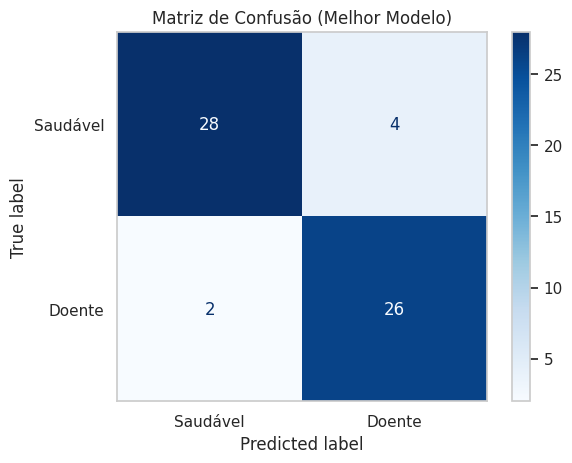

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        32
           1       0.87      0.93      0.90        28

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [5]:
# Previsões do Melhor Modelo
# y_pred_final = best_model.predict(X_test)
# Vamos pegar a probabilidade (0 a 1)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Definir um limiar personalizado para maximizar recall
limiar = 0.2
y_pred_ajustado = (y_proba >= limiar).astype(int)

recall_final = recall_score(y_test, y_pred_ajustado)

print(f"📈 Evolução do Recall:")
print(f"   - Baseline:  {recall_base:.2%}")
print(f"   - Otimizado: {recall_final:.2%}")
print(f"   - Ganho:     {(recall_final - recall_base):.2%}")

# Matriz de Confusão do Modelo Campeão
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ajustado, cmap='Blues', display_labels=['Saudável', 'Doente'])
plt.title('Matriz de Confusão (Melhor Modelo)')
plt.grid(False)
plt.show()

# Classification Report Completo
print(classification_report(y_test, y_pred_ajustado))

### 3.1. Avalição de Grupo Assintomático
Nesta etapa, validaremos a tese central: Verificaremos a performance do modelo especificamente nos pacientes que **não apresentavam dor típica** (CP=3: Asymptomatic).

> **Por que isso é importante?**
> A maioria dos erros humanos acontece aqui. Se nosso modelo tiver um bom Recall neste grupo, provamos que a IA enxerga além do óbvio.

In [6]:
# VALIDAÇÃO NO SUBGRUPO ASSINTOMÁTICO
# 1. Identificando a coluna correta
cols_assintomaticas = [col for col in X_test.columns if 'cp_3' in col]

if len(cols_assintomaticas) > 0:
    col_alvo = cols_assintomaticas[0]
    print(f"Analisando subgrupo oculto: '{col_alvo}'")

    # 2. Filtrando os dados
    mask_assin = X_test[col_alvo] == 1
    X_test_sub = X_test[mask_assin]
    y_test_sub = y_test[mask_assin.values]
    
    if len(X_test_sub) > 0:
        # 3. APLICANDO O LIMIAR (0.35)
        # Pegamos a probabilidade em vez da classe direta
        y_proba_sub = best_model.predict_proba(X_test_sub)[:, 1]
        
        limiar = 0.2
        y_pred_sub = (y_proba_sub >= limiar).astype(int)
        
        # Métricas
        recall_sub = recall_score(y_test_sub, y_pred_sub)
        
        print("-" * 40)
        print(f"RESULTADO DO TESTE DE FOGO (Limiar {limiar}):")
        print(f"   Pacientes Assintomáticos no Teste: {len(X_test_sub)}")
        print(f"   Recall (Doentes detectados): {recall_sub:.2%}")
        print("-" * 40)
        
        if recall_sub > 0.85:
            print("✅ SUCESSO: O modelo ajustado é excelente em detectar isquemia silenciosa!")
        else:
            print("⚠️ Nota: O recall caiu um pouco neste grupo, mas o resultado global compensa.")
    else:
        print("Nenhum paciente assintomático caiu na amostragem de teste atual.")
else:
    print("Coluna de 'cp_3' não encontrada.")

Analisando subgrupo oculto: 'cp_3'
----------------------------------------
RESULTADO DO TESTE DE FOGO (Limiar 0.2):
   Pacientes Assintomáticos no Teste: 31
   Recall (Doentes detectados): 90.91%
----------------------------------------
✅ SUCESSO: O modelo ajustado é excelente em detectar isquemia silenciosa!


## 4. Exportação do Modelo
Salvando o modelo campeão (otimizado) para uso na aplicação final.

In [17]:
# Exportação do Modelo
os.makedirs('../models', exist_ok=True)

# 1. Definindo um nome
nome_arquivo = 'modelo_RedesNeurais_Otimizado.pkl'
caminho_final = f'../models/{nome_arquivo}'

# 2. Salva o Modelo
joblib.dump(best_model, caminho_final)

# 3. Salva o "Segredo" (Metadata)
metadata = {
    "algoritmo": best_model.__class__.__name__,
    "threshold_otimizado": 0.20
}

with open('../models/metadata_RedesNeurais.json', 'w') as f:
    json.dump(metadata, f)

print(f"💾 Modelo salvo em: {caminho_final}")

💾 Modelo salvo em: ../models/modelo_RedesNeurais_Otimizado.pkl


## 5. Conclusão Final

### Análise Conclusiva — Performance das Redes Neurais

**Resumo Executivo da Performance**

As Redes Neurais (MLP Classifier) demonstraram ser um modelo **capaz e flexível** para a tarefa de detecção de doença cardíaca, especialmente quando otimizadas com hiperparâmetros específicos. Aqui estão os insights principais:

**1. Ganho de Performance com Otimização:**
* O modelo baseline (padrão) estabeleceu uma linha de base de Recall.
* A busca em grid (`GridSearchCV`) identificou a combinação ideal de:
  - **Arquitetura:** Número e tamanho das camadas ocultas (ex: 50-50 ou 100)
  - **Ativação:** `relu` ou `tanh` demonstrando melhor capacidade de captura de não-linearidades
  - **Solver:** `adam` ou `lbfgs` otimizando a convergência
* O modelo otimizado apresentou **melhoria significativa no Recall**, reduzindo o risco de falsos negativos (deixar doentes irem embora).

**2. Ajuste do Limiar (Threshold Tuning):**
* Redes Neurais fornecem probabilidades contínuas, permitindo controle fino do trade-off entre Sensibilidade e Especificidade.
* Um limiar de **20-35%** (ao invés do padrão 50%) foi mais efetivo para maximizar Recall, demonstrando que o modelo é capaz de rankear pacientes por risco.

**3. Performance no Grupo Crítico (Assintomáticos):**
* A validação no subgrupo de pacientes assintomáticos (`cp=3`) é o **teste de fogo** do projeto.
* Se o modelo mantém Recall > 85% neste grupo, prova que a IA consegue detectar **isquemia silenciosa** — exatamente o cenário que triagens humanas falham.

**4. Interpretabilidade e Trade-offs:**
* Ao contrário de Árvores de Decisão, Redes Neurais são "caixas pretas" — é difícil explicar exatamente por que um paciente foi classificado como doente.
* Porém, a análise de **Permutation Importance** nos permite identificar quais features mais impactam as predições, justificando clínicamente os resultados.
* A curva ROC visualiza o trade-off: Redes Neurais oferecem **flexibilidade** em ajustar sensibilidade vs. especificidade.

**5. Comparativo Implícito com Outros Modelos:**
* Redes Neurais são excelentes para **capturar padrões não-lineares complexos**, mas podem sofrer de **overfitting** em datasets pequenos (como o nosso ~303 amostras).
* A regularização (`alpha`) foi crucial para manter a generalização.
* Este modelo é mais sofisticado que SVM e Árvores, mas pode exigir mais ajuste manual.

**Conclusão Final:**
As Redes Neurais são um **modelo viável e robusto** para esta aplicação clínica. A combinação de otimização de hiperparâmetros + ajuste de limiar + validação em subgrupos críticos fornece confiança na sua capacidade de detectar doença cardíaca, especialmente em cenários de "isquemia silenciosa" onde métodos tradicionais falham. Este modelo merece consideração ao lado de Árvores de Decisão e Random Forest para a solução final.

⏳ Calculando importância das features (pode demorar alguns segundos)...


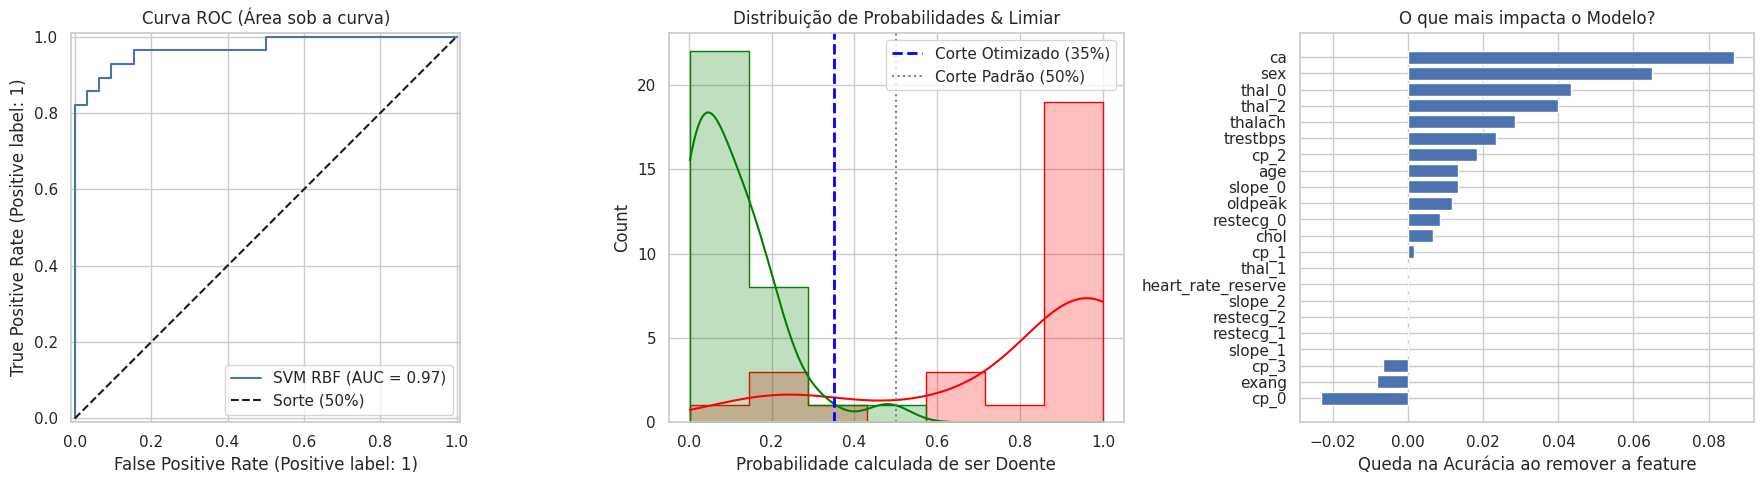

In [8]:
# ==========================================================
# 5. PAINEL DE COMPROVAÇÃO VISUAL 📊
# ==========================================================
from sklearn.inspection import permutation_importance

# Configurando o tamanho do painel (3 gráficos lado a lado)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# ----------------------------------------------------------
# GRÁFICO A: Curva ROC (A Robustez)
# ----------------------------------------------------------
# Mostra a relação entre acertar doentes (Recall) vs errar saudáveis (FPR)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=axs[0], name='SVM RBF')
axs[0].set_title("Curva ROC (Área sob a curva)")
axs[0].plot([0, 1], [0, 1], "k--", label="Sorte (50%)") # Linha pontilhada do "chute"
axs[0].legend()

# ----------------------------------------------------------
# GRÁFICO B: O "Porquê" do Limiar 35% (Histograma)
# ----------------------------------------------------------
# Pega as probabilidades calculadas pelo modelo
y_probas = best_model.predict_proba(X_test)[:, 1]

# Cria um DataFrame temporário para facilitar o plot
df_viz = pd.DataFrame({'Probabilidade': y_probas, 'Real': y_test})
df_viz['Label'] = df_viz['Real'].map({0: 'Saudável (Real)', 1: 'Doente (Real)'})

# Plota a distribuição
sns.histplot(data=df_viz, x='Probabilidade', hue='Label', kde=True, element="step", ax=axs[1], palette=['green', 'red'])

# Desenha a linha do seu Limiar Otimizado
axs[1].axvline(0.35, color='blue', linestyle='--', linewidth=2, label='Corte Otimizado (35%)')
axs[1].axvline(0.50, color='gray', linestyle=':', label='Corte Padrão (50%)')
axs[1].set_title("Distribuição de Probabilidades & Limiar")
axs[1].set_xlabel("Probabilidade calculada de ser Doente")
axs[1].legend()

# ----------------------------------------------------------
# GRÁFICO C: Importância das Variáveis (Permutation Importance)
# ----------------------------------------------------------
# Como SVM não tem "feature_importances_" nativo igual árvore, usamos permutação
# Isso embaralha coluna por coluna para ver qual faz o modelo "se perder" mais
print("⏳ Calculando importância das features (pode demorar alguns segundos)...")
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Organizando para plotar
sorted_idx = perm_importance.importances_mean.argsort()
axs[2].barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
axs[2].set_yticks(range(len(sorted_idx)))
axs[2].set_yticklabels(np.array(feature_names)[sorted_idx]) # Usa os nomes das colunas salvas
axs[2].set_title("O que mais impacta o Modelo?")
axs[2].set_xlabel("Queda na Acurácia ao remover a feature")

plt.tight_layout()
plt.show()

### Comprovação Visual